### *Step 1: Importing necessary libraries*

In [1]:
import re
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from pandas import DataFrame 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

<Figure size 640x480 with 0 Axes>

### *Step 2: Reading the Dataset*

In [2]:
df = pd.read_json('./Data/Prime_Pantry.json', lines=True) #with pandas
df.head() #displaying top 5 rows

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4,NaN,NaN
4,4,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN


In [3]:
#checking the shape
df.shape

(471614, 12)

### *Step 3: Dataset pre-processing*
> Performing **product** based colloborative filtering

In [4]:
#grouping by on product id (which is asin) on bases of count and mean
grp_count = df.groupby("asin", as_index=False).count()
#grp_mean = df.groupby("asin", as_index=False).mean()

#joining the dataframes
df_joined = pd.merge(df, grp_count, how='right', on=['asin'])
df_joined.head()

,overall_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,vote_x,...,verified_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,vote_y,image_y,style_y
0,2,False,"09 20, 2017",A2HZ0F1Q8CVX1,B00005BPJO,Heather Haskins,The outside of them is wet and sticky.. like t...,Sticky and stale,1505865600,NaN,...,10,10,10,10,10,10,10,7,0,0
1,3,True,"03 23, 2016",A3C4FVGQ0FSORL,B00005BPJO,Amazon shopper,They came white,Three Stars,1458691200,NaN,...,10,10,10,10,10,10,10,7,0,0
2,4,False,"07 17, 2015",A2582KMXLK2P06,B00005BPJO,Bryan,"I used to hate Milk Duds for the longest time,...",milky deliciousness,1437091200,2,...,10,10,10,10,10,10,10,7,0,0
3,5,True,"05 30, 2015",A1CSVASI7B3RTX,B00005BPJO,Sadie,Very good,Five Stars,1432944000,2,...,10,10,10,10,10,10,10,7,0,0
4,5,False,"10 13, 2014",A2K7V3G4598QRF,B00005BPJO,Daydreamer,I love these. The chocolate is really good and...,These are really good.,1413158400,NaN,...,10,10,10,10,10,10,10,7,0,0


In [5]:
#renaming columns
df_joined["num_reviewers"] = df_joined["reviewerID_y"]
df_joined["total_score"] = df_joined["overall_x"]
df_joined["review_summary"] = df_joined["summary_x"]

#making a new df containing just three columns
df_final = df_joined[['asin','review_summary','total_score',"num_reviewers"]]

<AxesSubplot:>

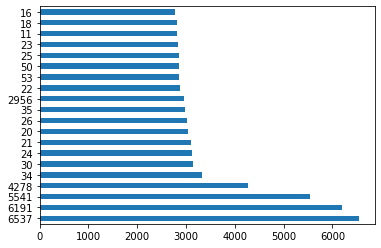

In [6]:
df_joined["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [7]:
#selecting reviews which were reviewed by more than 80 users
df_joined = df_joined.sort_values(by='num_reviewers', ascending=False)
df_joined_above_50 = df_joined[df_joined.num_reviewers >= 80]
df_joined_above_50.head()

,overall_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,vote_x,...,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,vote_y,image_y,style_y,num_reviewers,total_score,review_summary
95168,5,True,"03 18, 2018",A3Q7NGN14THEQN,B00I3MVY9I,Sichuan,I was surprised at how well this worked. I thi...,Effective!,1521331200,NaN,...,6535,6527,6537,6537,536,89,0,6537,5,Effective!
97253,5,True,"04 30, 2016",A1HK96JOR9S41X,B00I3MVY9I,A.E.I,Love this product. I can't already see a chang...,Five Stars,1461974400,NaN,...,6535,6527,6537,6537,536,89,0,6537,5,Five Stars
97243,5,True,"05 2, 2016",A3TS3EHK165MUY,B00I3MVY9I,Siri Amrit Ramos,Great! Just what you'd expect. Does make my te...,Shiny teeth for months,1462147200,NaN,...,6535,6527,6537,6537,536,89,0,6537,5,Shiny teeth for months
97244,5,True,"05 2, 2016",A3LDY0IZFH8URP,B00I3MVY9I,Amazon Customer,My teeth are looking so much better thanks to ...,It actually works,1462147200,NaN,...,6535,6527,6537,6537,536,89,0,6537,5,It actually works
97245,4,True,"05 2, 2016",A32QY0TB7B6R73,B00I3MVY9I,AudC,I was expecting a dramatic difference based on...,Although I'm happy with the results,1462147200,NaN,...,6535,6527,6537,6537,536,89,0,6537,4,Although I'm happy with the results


<AxesSubplot:>

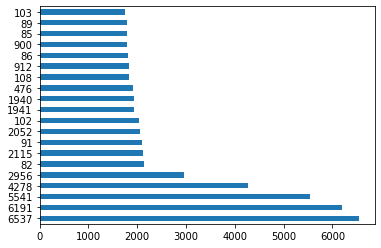

In [8]:
df_joined_above_50["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [9]:
#making final product reviews dataset
df_product = df.groupby("asin", as_index=False).mean()
df_product_review = df_joined_above_50.groupby("asin")["review_summary"].apply(list)
df_product_review = pd.DataFrame(df_product_review)
df_product_review.to_csv("appliances_product_summary.csv")

In [10]:
df_product_review.head()

,review_summary
asin,
B00032E8XK,"[Five Stars, Good Tasting Tuna - Recommended, ..."
B00099XLXU,"[One Star, Bottom of 1 of containers was not i..."
B00099XNXS,"[Not as good as I remembered as a kid, Four St..."
B00099XO3W,"[Five Stars, Favorite tomato soup, Four Stars,..."
B00099XO50,"[Five Stars, Five Stars, Love 'Em!, Pantry sta..."


In [11]:
#merging
df_product_review = pd.read_csv("appliances_product_summary.csv")
df_product_review = pd.merge(df_product_review, df_product, on="asin", how='inner')

In [12]:
df_product_review = df_product_review[['asin','review_summary','overall']]
df_product_review.head()

,asin,review_summary,overall
0,B00032E8XK,"['Five Stars', 'Good Tasting Tuna - Recommende...",4.100418
1,B00099XLXU,"['One Star', 'Bottom of 1 of containers was no...",4.439189
2,B00099XNXS,"['Not as good as I remembered as a kid', 'Four...",4.209596
3,B00099XO3W,"['Five Stars', 'Favorite tomato soup', 'Four S...",4.244444
4,B00099XO50,"['Five Stars', 'Five Stars', ""Love 'Em!"", 'Pan...",4.224719


In [13]:
df_ranges = pd.crosstab(df_product_review['asin'], pd.cut(df_product_review['overall'], [2, 2.5, 3.0, 3.5, 4.0, 4.5, 5]))
df_ranges.head()

overall,"(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"
asin,,,,,,
B00032E8XK,0,0,0,0,1,0
B00099XLXU,0,0,0,0,1,0
B00099XNXS,0,0,0,0,1,0
B00099XO3W,0,0,0,0,1,0
B00099XO50,0,0,0,0,1,0


<AxesSubplot:xlabel='overall'>

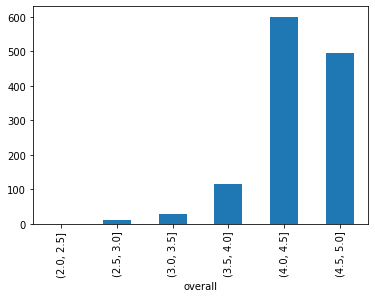

In [14]:
df_ranges.sum().plot.bar()

<AxesSubplot:>

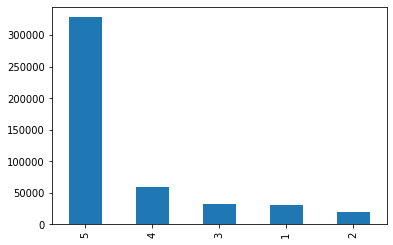

In [15]:
df['overall'].value_counts().plot(kind='bar')

### *Step 4: Text Cleaning*

In [16]:
#tokenizing text
reg = re.compile('[^a-z]+')
def cleanText(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [17]:
#drop duplicate rows
df_product_review["cleaned_review"] = df_product_review["review_summary"].apply(cleanText)
df_product_review = df_product_review.drop_duplicates(['overall'], keep='last')
df_product_review = df_product_review.reset_index()

In [18]:
#count vectorization
reviews = df_product_review["cleaned_review"] 
countVector = CountVectorizer(max_features = 200, stop_words='english') 
transformed_reviews = countVector.fit_transform(reviews) 

df_reviews = DataFrame(transformed_reviews.A, columns=countVector.get_feature_names())
df_reviews = df_reviews.astype(int)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
#save 
df_reviews.to_csv("appliances_reviews.csv")

### *Step 5: Train Test Split*

In [20]:
X = np.array(df_reviews)
train_test_ratio = 0.9
size = int(np.floor(train_test_ratio * len(X)))
X_train = X[:size]
X_test = X[size:]

In [21]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)
distances, indices = neighbor.kneighbors(X_train)

### Step 6: *Finding related products*

In [22]:
#find most related products
for i in range(len(X_test)):
    product_test = neighbor.kneighbors([X_test[i]])
    related_products = product_test[1]

    related_product_1 = [item[0] for item in related_products]
    related_product_1 = str(related_product_1).strip('[]')
    related_product_1 = int(related_product_1)
    
    related_product_2 = [item[1] for item in related_products]
    related_product_2 = str(related_product_2).strip('[]')
    related_product_2 = int(related_product_2)
    
    print ("Based on product reviews, for ", df_product_review["asin"][len(X_train) + i] ," average rating is ",df_product_review["overall"][len(X_train) + i])
    print ("The first similar product is ", df_product_review["asin"][related_product_1] ," average rating is ",df_product_review["overall"][related_product_1])
    print ("The second similar product is ", df_product_review["asin"][related_product_2] ," average rating is ",df_product_review["overall"][related_product_2])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B01890O0K8  average rating is  3.752577319587629
The first similar product is  B00I8GMBDW  average rating is  4.348314606741573
The second similar product is  B010NE4U08  average rating is  4.086206896551724
-----------------------------------------------------------
Based on product reviews, for  B01892J858  average rating is  4.205128205128205
The first similar product is  B00N0WZSOS  average rating is  4.038461538461538
The second similar product is  B015O6PSO2  average rating is  4.329831932773109
-----------------------------------------------------------
Based on product reviews, for  B018E4UPYY  average rating is  3.2268041237113403
The first similar product is  B00QJGT51E  average rating is  2.7373737373737375
The second similar product is  B00QJGWAU2  average rating is  2.1744186046511627
-----------------------------------------------------------
Based on product reviews, for  B018FRY5X2  average rating is  4.815533980582524
The first similar pr

In [23]:
y_train = df_product_review["overall"][:len(X_train)].apply(np.ceil)
y_test = df_product_review["overall"][len(X_train):len(X_train)+len(X_test)].apply(np.ceil)

### *Over Sampling*

<AxesSubplot:>

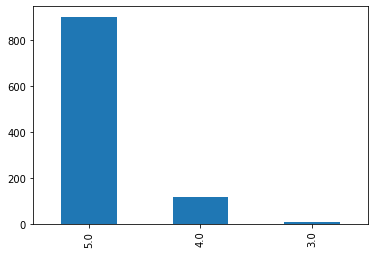

In [24]:
#before over sampling
y_train.value_counts().plot(kind='bar')

In [25]:
# over = SMOTE(k_neighbors=3)
# X_train, y_train = over.fit_resample(X_train, y_train)

In [26]:
# #after over sampling
# y_train.value_counts().plot(kind='bar')

### *Apply kNN*

In [27]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.40      0.09      0.15        22
         5.0       0.83      0.98      0.90        92

    accuracy                           0.80       115
   macro avg       0.41      0.36      0.35       115
weighted avg       0.74      0.80      0.74       115



In [28]:
print (accuracy_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.8
0.2


In [29]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanText)

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

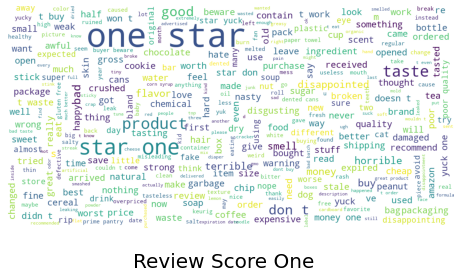

In [31]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

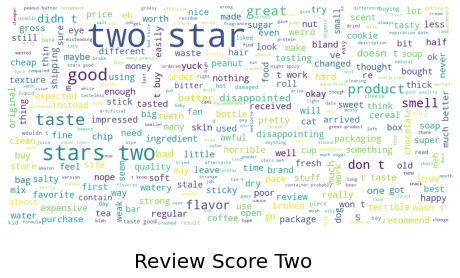

In [32]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Score Two")

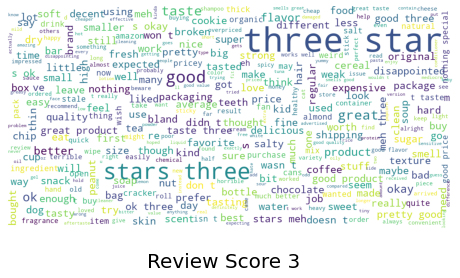

In [33]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score 3")

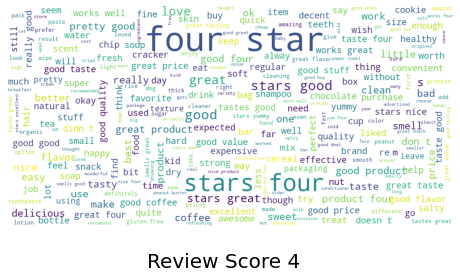

In [34]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score 4")

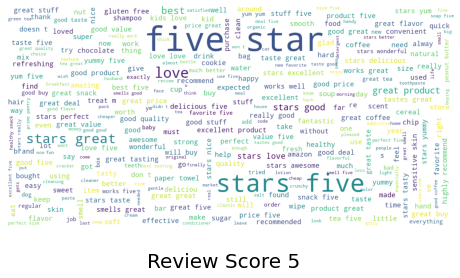

In [35]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score 5")

In [36]:
errors = []
K = range(1,10)
for k in K:
    model  = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'Error Rate')

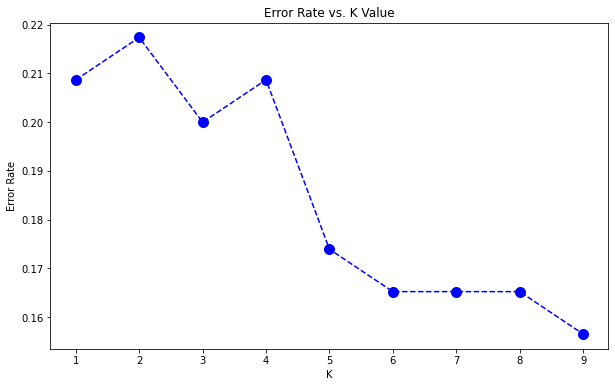

In [37]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10), errors, color='blue', linestyle='dashed', marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [38]:
clf = neighbors.KNeighborsClassifier(9, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print ("Accuracy: ",accuracy_score(y_test, pred))
print("MSE: ",mean_squared_error(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.83      0.23      0.36        22
         5.0       0.84      1.00      0.92        92

    accuracy                           0.84       115
   macro avg       0.56      0.41      0.42       115
weighted avg       0.83      0.84      0.80       115

Accuracy:  0.8434782608695652
MSE:  0.1565217391304348


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
